# Segmentation + Evaluation

In [ ]:
# %% [markdown]
"""
# 04 Model Evaluation · **Optic Disc/Cup Segmentation**

*Last sync 01 Aug 2025*

This notebook evaluates the performance of the `gemini_seg` function for segmenting the
optic disc and optic cup from fundoscopic images in the REFUGE2 dataset. It systematically
calculates and aggregates key performance and clinical metrics by comparing the model's
output against ground-truth data.

**Key Features (Adapted for REFUGE2):**
- **Multi-Class Evaluation:** Compares predicted vs. ground truth masks on a per-label basis ("optic disc", "optic cup").
- **Clinically Relevant Metrics:** Calculates Dice Score, Intersection over Union (IoU), and Vertical Cup-to-Disc Ratio (vCDR) Mean Absolute Error.
- **Configurable & Self-Contained:** Automatically generates the master image list and allows for easy configuration of model, test size, and other parameters.
- **Flexible Analysis:** A toggle (`EXCLUDE_LOW_IOU_FROM_STATS`) allows metrics and plots to be generated for either all images or only successful detections.
- **Robust Failure Analysis:** Categorizes and saves lists of failed images (JSON errors, false negatives per class, low IoU per class) for detailed review.
- **Bootstrapped Confidence Intervals:** An optional toggle (`ENABLE_BOOTSTRAPPING`) enables the calculation of 95% confidence intervals for all key metrics.
- **Publication-Ready Outputs:** Saves a detailed JSON summary and high-resolution (600 DPI) plots of the IoU distributions for both disc and cup.
- **Robust API Handling:** Includes rate limiting, client-side request timeouts, and prediction caching.
"""

# %%
# ---------- Preamble & Setup ----------
import sys, logging, os, subprocess, importlib.util, json, io, random, base64, dataclasses, time
from datetime import datetime
from pathlib import Path
from typing import Tuple, List, Dict
from concurrent.futures import ThreadPoolExecutor, TimeoutError

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont, ImageColor, UnidentifiedImageError
from tqdm.notebook import tqdm
from dotenv import load_dotenv, find_dotenv

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s — %(levelname)s — %(message)s",
    datefmt="%Y-m-%d %H:%M:%S",
)
logging.info("Evaluation notebook start.")

# %%
# ---------- Ensure helper packages ----------
def _ensure(pkg: str):
    """Checks if a package is installed and installs it if not."""
    if importlib.util.find_spec(pkg) is None:
        logging.info("Installing %s (missing)", pkg)
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "--quiet"])

for extra in ("python-dotenv", "tqdm", "matplotlib", "numpy", "Pillow", "google-genai", "pandas"):
    _ensure(extra)

# %%
# ---------- GenAI Client & Dataset Paths ----------
load_dotenv(find_dotenv(), override=False)

from google import genai
from google.genai.types import GenerateContentConfig, Part, ThinkingConfig

if not os.getenv("GOOGLE_API_KEY"):
    raise ValueError("GOOGLE_API_KEY not found. Ensure it is in your .env file.")

client = genai.Client()
logging.info("GenAI client initialized.")


dataset_dir = Path(os.getenv("REFUGE_DIR", "data/REFUGE2")).expanduser().resolve()
if not dataset_dir.is_dir():
    raise FileNotFoundError(f"Dataset directory not found at {dataset_dir}.")
logging.info("REFUGE2 dataset found at %s", dataset_dir)

# %% [markdown]
"""
### Core Functions (Adapted for Multi-Class)

This section includes the necessary functions for segmentation and evaluation, adapted for the optic disc/cup task.

**Key Modifications:**
- **`PROMPT`:** Updated to request segmentation of the "optic disc" and "optic cup".
- **`parse_ground_truth_mask`:** A new function to extract separate masks for the disc and cup from the color-coded ground truth `.bmp` files.
- **`gemini_seg`:** Retains its robust error handling and timeout features.
- **`save_prediction_details`:** Unchanged, saves the model's raw output for caching.
"""

# %%
# ---------- Core Segmentation & Parsing Logic ----------

@dataclasses.dataclass(frozen=True)
class SegmentationMask:
    """A dataclass to hold a single segmentation mask's data."""
    y0: int
    x0: int
    y1: int
    x1: int
    mask: np.ndarray # Full-size mask [img_height, img_width] with values 0..255
    label: str

def parse_json(json_output: str) -> str:
    """Cleans the model's JSON output by removing markdown fencing."""
    lines = json_output.splitlines()
    for i, line in enumerate(lines):
        if line.strip() == "```json":
            json_content = "\n".join(lines[i+1:])
            closing_fence_index = json_content.find("```")
            if closing_fence_index != -1:
                json_content = json_content[:closing_fence_index]
            return json_content.strip()
    return json_output.strip()

def parse_segmentation_masks(
    predicted_str: str, *, img_height: int, img_width: int
) -> Tuple[List[SegmentationMask], bool]:
    """
    Parses the model's JSON output into a list of SegmentationMask objects.
    Returns the list of masks and a boolean indicating if JSON parsing was successful.
    """
    cleaned_json = parse_json(predicted_str)
    if not cleaned_json:
        logging.warning("Parsing model output resulted in an empty string.")
        return [], True # Technically not a JSON error, but an empty response.

    try:
        items = json.loads(cleaned_json)
        parse_success = True
    except json.JSONDecodeError as e:
        logging.error(f"Failed to decode JSON: {e}")
        logging.error(f"Problematic string after cleaning: {cleaned_json}")
        return [], False

    masks = []
    for item in items:
        try:
            abs_y0 = int(item["box_2d"][0] / 1000 * img_height)
            abs_x0 = int(item["box_2d"][1] / 1000 * img_width)
            abs_y1 = int(item["box_2d"][2] / 1000 * img_height)
            abs_x1 = int(item["box_2d"][3] / 1000 * img_width)

            if abs_y0 >= abs_y1 or abs_x0 >= abs_x1:
                continue

            label = item["label"].lower() # Standardize label to lowercase
            png_b64_str = item["mask"]
            png_bytes = base64.b64decode(png_b64_str.removeprefix("data:image/png;base64,"))
            partial_mask_img = Image.open(io.BytesIO(png_bytes))

            bbox_height = abs_y1 - abs_y0
            bbox_width = abs_x1 - abs_x0
            resized_mask = partial_mask_img.resize((bbox_width, bbox_height), resample=Image.Resampling.BILINEAR)
            full_mask_np = np.zeros((img_height, img_width), dtype=np.uint8)
            full_mask_np[abs_y0:abs_y1, abs_x0:abs_x1] = np.array(resized_mask)

            masks.append(SegmentationMask(abs_y0, abs_x0, abs_y1, abs_x1, full_mask_np, label))
        except (KeyError, IndexError, TypeError, base64.binascii.Error, UnidentifiedImageError) as e:
            logging.warning(f"Skipping malformed item in JSON response: {item}. Error: {e}")
            continue
    return masks, parse_success

def parse_ground_truth_mask(mask_path: Path) -> list[SegmentationMask]:
    """
    Parses a REFUGE2 ground truth BMP/PNG file into separate SegmentationMasks for disc and cup.
    - Optic Cup: Black (0, 0, 0)
    - Optic Disc Ring: Gray (128, 128, 128)
    """
    try:
        mask_img = Image.open(mask_path).convert("RGB")
        mask_data = np.array(mask_img)
    except (FileNotFoundError, UnidentifiedImageError) as e:
        logging.error("Could not read ground truth mask file %s: %s", mask_path, e)
        return []

    CUP_COLOR = np.array([0, 0, 0])
    DISC_COLOR = np.array([128, 128, 128])

    is_cup = np.all(mask_data == CUP_COLOR, axis=-1)
    is_disc_ring = np.all(mask_data == DISC_COLOR, axis=-1)
    is_disc = is_cup | is_disc_ring

    masks = []
    for label, binary_mask_data in [("optic cup", is_cup), ("optic disc", is_disc)]:
        if not np.any(binary_mask_data):
            continue
        rows, cols = np.where(binary_mask_data)
        y0, y1 = rows.min(), rows.max()
        x0, x1 = cols.min(), cols.max()
        full_mask_np = binary_mask_data.astype(np.uint8) * 255
        masks.append(SegmentationMask(y0, x0, y1, x1, full_mask_np, label))

    return masks

PROMPT = (
    'Give the segmentation masks for the optic disc and the optic cup in this retinal '
    'fundus image. Output a JSON list of two segmentation masks. One entry should have '
    'the label "optic disc" and the other "optic cup". Each entry must contain the '
    '2D bounding box in "box_2d", the segmentation mask in "mask", and the text '
    'label in "label".'
)

def gemini_seg(image_obj: Image.Image, model_name: str, thinking_budget: int) -> Tuple[List[SegmentationMask], float, bool]:
    """
    Sends a PIL Image object to Gemini and returns segmentation masks, with a client-side timeout.
    """
    original_width, original_height = image_obj.size
    
    img_for_api = image_obj.copy()
    max_dim = 1024
    if img_for_api.height > max_dim or img_for_api.width > max_dim:
        img_for_api.thumbnail((max_dim, max_dim))

    with io.BytesIO() as img_byte_arr:
        img_for_api.save(img_byte_arr, format='JPEG')
        img_bytes = img_byte_arr.getvalue()

    gen_config = GenerateContentConfig(
        thinking_config=ThinkingConfig(thinking_budget=thinking_budget),
        temperature=0.5
    )
    image_part = Part.from_bytes(data=img_bytes, mime_type='image/jpeg')
    text_part = Part(text=PROMPT)
    
    def do_api_call():
        return client.models.generate_content(
            model=model_name, contents=[image_part, text_part], config=gen_config
        )

    start_time = datetime.now()
    try:
        if ENABLE_REQUEST_TIMEOUT:
            with ThreadPoolExecutor(max_workers=1) as executor:
                future = executor.submit(do_api_call)
                response = future.result(timeout=REQUEST_TIMEOUT_SEC)
        else:
            response = do_api_call()
        
        latency = (datetime.now() - start_time).total_seconds()
        masks, parse_success = parse_segmentation_masks(
            response.text, img_height=original_height, img_width=original_width
        )
        return masks, latency, parse_success

    except TimeoutError:
        logging.error(f"API call timed out after {REQUEST_TIMEOUT_SEC} seconds.")
        return [], 0.0, False
    except Exception as e:
        logging.error(f"An error occurred during the gemini_seg function.", exc_info=True)
        return [], 0.0, False

def save_prediction_details(masks: List[SegmentationMask], output_path: Path):
    """Saves the detailed contents of SegmentationMask objects to a JSON file."""
    if not masks:
        output_path.write_text(json.dumps([]))
        return

    results_to_save = []
    for mask_obj in masks:
        pil_img = Image.fromarray(mask_obj.mask)
        with io.BytesIO() as buffer:
            pil_img.save(buffer, format="PNG")
            png_bytes = buffer.getvalue()
        b64_string = base64.b64encode(png_bytes).decode('utf-8')
        results_to_save.append({
            "label": mask_obj.label,
            "box_2d_absolute": [mask_obj.y0, mask_obj.x0, mask_obj.y1, mask_obj.x1],
            "mask_b64": f"data:image/png;base64,{b64_string}"
        })
    with open(output_path, 'w') as f:
        json.dump(results_to_save, f, indent=2)

# %% [markdown]
"""
### Metric Calculation Utilities

These functions implement the formulas for Intersection over Union (IoU), the Dice Coefficient, the Vertical Cup-to-Disc Ratio (vCDR), and bootstrapping for confidence intervals.
"""

# %%
# ---------- Metric Calculation Functions ----------

def calculate_iou(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Calculates Intersection over Union (IoU) for boolean masks."""
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    if np.sum(union) == 0: return 1.0
    return np.sum(intersection) / np.sum(union)

def calculate_dice(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Calculates the Dice Coefficient for boolean masks."""
    intersection = np.sum(np.logical_and(y_true, y_pred))
    denominator = np.sum(y_true) + np.sum(y_pred)
    if denominator == 0: return 1.0
    return (2. * intersection) / (denominator + 1e-7)

def calculate_vcdr(mask_cup: np.ndarray, mask_disc: np.ndarray) -> float:
    """Calculates the vertical cup-to-disc ratio from binary masks."""
    try:
        cup_rows = np.where(mask_cup)[0]
        disc_rows = np.where(mask_disc)[0]
        if cup_rows.size == 0 or disc_rows.size == 0: return 0.0
        h_cup = cup_rows.max() - cup_rows.min() + 1
        h_disc = disc_rows.max() - disc_rows.min() + 1
        return h_cup / h_disc
    except Exception:
        return 0.0 # Return 0 if calculation fails

def calculate_bootstrap_ci(data: List[float], n_resamples: int = 1000) -> Tuple[float, float]:
    """Calculates the 95% confidence interval for a list of numbers using bootstrapping."""
    if not data or len(data) < 2: return 0.0, 0.0
    bootstrapped_means = [np.mean(np.random.choice(data, size=len(data), replace=True)) for _ in range(n_resamples)]
    return np.percentile(bootstrapped_means, 2.5), np.percentile(bootstrapped_means, 97.5)

# %% [markdown]
"""
### Evaluation Execution

This is the main loop of the notebook. It will:
1.  Generate a master list of valid image-mask pairs from the REFUGE2 directory.
2.  Randomly sample a specified number of images (`NUM_IMAGES_TO_TEST`).
3.  Iterate through each image, calling `gemini_seg` and parsing the ground truth.
4.  Match predicted masks to ground truth masks by label ("optic disc", "optic cup").
5.  Calculate IoU, Dice, and vCDR for each image and store the results.
6.  Categorize and log any failures (e.g., parsing errors, missed detections).
"""

# %%
# ---------- Main Evaluation Loop ----------

# <<< --- PARAMETERS TO CONTROL THE EVALUATION --- >>>
MODEL_NAME = "gemini-2.5-pro" # Options: 'gemini-2.5-pro', 'gemini-2.5-flash', 'gemini-2.5-flash-lite'
THINKING_BUDGET = 128 # 0 for 'gemini-2.5-flash' and 'gemini-2.5-flash-lite', 128 for 'gemini-2.5-pro'
NUM_IMAGES_TO_TEST = 0 # Set to None or 0 to test all images
SAVE_PREDICTIONS = True
ENABLE_BOOTSTRAPPING = True
ENABLE_RATE_LIMITING = False
RATE_LIMIT_DELAY_SEC = 9
ENABLE_REQUEST_TIMEOUT = True
REQUEST_TIMEOUT_SEC = 300
LOW_IOU_THRESHOLD = 0.5
EXCLUDE_LOW_IOU_FROM_STATS = False # If True, stats/plots only use runs with IoU >= threshold. If False, all runs are used.

model_name_safe = MODEL_NAME.replace("/", "_")
logging.info(f"Starting evaluation run for model: {MODEL_NAME} on REFUGE2 dataset.")

# --- Generate Master Image List if it Doesn't Exist ---
master_list_path = dataset_dir / "master_imagelist_refuge2.txt"
if not master_list_path.exists():
    logging.info(f"Master image list not found. Generating it now at: {master_list_path}")
    image_paths = sorted(dataset_dir.glob("**/image/*.jpg"))
    # Find both .bmp and .png masks and merge them.
    bmp_masks = {p.stem: p for p in dataset_dir.glob("**/mask/*.bmp")}
    png_masks = {p.stem: p for p in dataset_dir.glob("**/mask/*.png")}
    mask_map = {**bmp_masks, **png_masks} # Merges dictionaries, png will overwrite bmp if stems conflict.
    
    valid_pairs = [p for p in image_paths if p.stem in mask_map]
    if not valid_pairs:
        raise RuntimeError("No valid image-mask pairs found in the dataset directories.")
    master_list_path.write_text("\n".join(str(p) for p in valid_pairs))
    logging.info(f"Successfully generated master list with {len(valid_pairs)} images.")

# --- Create Model-Specific Predictions Directory ---
if SAVE_PREDICTIONS:
    predictions_dir = dataset_dir / f"predictions_{model_name_safe}"
    predictions_dir.mkdir(exist_ok=True)
    logging.info(f"Detailed predictions will be saved to: {predictions_dir}")

# --- Load and Prepare Evaluation Set ---
with open(master_list_path, 'r') as f:
    all_available_paths = [Path(line.strip()) for line in f.readlines()]
num_available = len(all_available_paths)
random.seed(42)
random.shuffle(all_available_paths) # Shuffle once for random sampling

# Determine the final set of images to evaluate
if NUM_IMAGES_TO_TEST is None or NUM_IMAGES_TO_TEST <= 0:
    logging.info(f"NUM_IMAGES_TO_TEST is not set. Evaluating all {num_available} available images.")
    images_to_evaluate = all_available_paths
else:
    num_to_test = min(NUM_IMAGES_TO_TEST, num_available)
    if NUM_IMAGES_TO_TEST > num_available:
        logging.warning(
            f"Requested {NUM_IMAGES_TO_TEST} images, but only {num_available} are available. "
            f"Proceeding with all {num_available} images."
        )
    images_to_evaluate = all_available_paths[:num_to_test]

logging.info(f"Loaded {num_available} total images. Will evaluate a sample of {len(images_to_evaluate)}.")

# --- Create a complete mask map for efficient lookup during the loop ---
bmp_masks = {p.stem: p for p in dataset_dir.glob("**/mask/*.bmp")}
png_masks = {p.stem: p for p in dataset_dir.glob("**/mask/*.png")}
full_mask_map = {**bmp_masks, **png_masks}


# --- Initialize storage for results and failures ---
evaluation_results = []
json_failures, fn_disc_failures, fn_cup_failures = [], [], []
low_iou_disc_failures, low_iou_cup_failures = [], []

for img_path in tqdm(images_to_evaluate, desc=f"Evaluating {model_name_safe}"):
    try:
        logging.info(f"Processing: {img_path.name}")
        original_image = Image.open(img_path)

        predicted_masks, latency, parse_success = gemini_seg(original_image, MODEL_NAME, THINKING_BUDGET)

        if SAVE_PREDICTIONS:
            prediction_output_path = predictions_dir / f"{img_path.stem}.json"
            save_prediction_details(predicted_masks, prediction_output_path)

        # Find the corresponding mask path using the pre-built map
        mask_path = full_mask_map.get(img_path.stem)
        if not mask_path:
            logging.warning(f"Could not find matching mask for image {img_path.name}. Skipping.")
            continue
            
        gt_masks = parse_ground_truth_mask(mask_path)

        # --- Create label-to-mask mappings for easy comparison ---
        gt_map = {m.label: m.mask for m in gt_masks}
        pred_map = {m.label: m.mask for m in predicted_masks}

        # --- Calculate metrics for each class ---
        iou_disc = calculate_iou(gt_map.get('optic disc') > 127, pred_map.get('optic disc', np.zeros_like(gt_map.get('optic disc'))) > 127)
        iou_cup = calculate_iou(gt_map.get('optic cup') > 127, pred_map.get('optic cup', np.zeros_like(gt_map.get('optic cup'))) > 127)
        dice_disc = calculate_dice(gt_map.get('optic disc') > 127, pred_map.get('optic disc', np.zeros_like(gt_map.get('optic disc'))) > 127)
        dice_cup = calculate_dice(gt_map.get('optic cup') > 127, pred_map.get('optic cup', np.zeros_like(gt_map.get('optic cup'))) > 127)
        
        vcdr_gt = calculate_vcdr(gt_map.get('optic cup') > 127, gt_map.get('optic disc') > 127)
        vcdr_pred = calculate_vcdr(pred_map.get('optic cup', np.zeros_like(gt_map.get('optic cup'))) > 127, pred_map.get('optic disc', np.zeros_like(gt_map.get('optic disc'))) > 127)

        # --- Categorize Failures ---
        if not parse_success:
            json_failures.append(img_path.name)
        else:
            # False Negative: No prediction was returned for this class.
            if 'optic disc' not in pred_map: 
                fn_disc_failures.append(img_path.name)
            # Low IoU: A prediction was returned, but it was poor.
            elif iou_disc < LOW_IOU_THRESHOLD: 
                low_iou_disc_failures.append(img_path.name)
            
            if 'optic cup' not in pred_map: 
                fn_cup_failures.append(img_path.name)
            elif iou_cup < LOW_IOU_THRESHOLD: 
                low_iou_cup_failures.append(img_path.name)

        evaluation_results.append({
            "image_path": img_path.name, "latency_sec": latency, "parse_success": parse_success,
            "iou_disc": iou_disc, "iou_cup": iou_cup,
            "dice_disc": dice_disc, "dice_cup": dice_cup,
            "vcdr_gt": vcdr_gt, "vcdr_pred": vcdr_pred,
        })

    except Exception as e:
        logging.error(f"An unexpected error occurred while processing {img_path.name}", exc_info=True)
        evaluation_results.append({
            "image_path": img_path.name, "latency_sec": 0, "parse_success": False,
            "iou_disc": 0, "iou_cup": 0, "dice_disc": 0, "dice_cup": 0,
            "vcdr_gt": 0, "vcdr_pred": 0,
        })
    
    if ENABLE_RATE_LIMITING:
        time.sleep(RATE_LIMIT_DELAY_SEC)

logging.info("Evaluation loop complete.")

# %% [markdown]
"""
### Failure Analysis & Reporting

This section saves the lists of failed images to model-specific text files for easier manual review. Failures are categorized by type (JSON error, false negative, low IoU) and by class (disc, cup).
"""

# %%
# ---------- Save Failure Lists to Files ----------
def save_failure_list(failure_list: List[str], failure_type: str, model_name: str):
    """Saves a list of failed image names to a text file."""
    if failure_list:
        failure_path = dataset_dir / f"failures_{failure_type}_{model_name}.txt"
        logging.info(f"Saving {len(failure_list)} {failure_type} failures to {failure_path}")
        failure_path.write_text("\n".join(failure_list))

save_failure_list(json_failures, "json", model_name_safe)
save_failure_list(fn_disc_failures, "fn_disc", model_name_safe)
save_failure_list(fn_cup_failures, "fn_cup", model_name_safe)
save_failure_list(low_iou_disc_failures, "low_iou_disc", model_name_safe)
save_failure_list(low_iou_cup_failures, "low_iou_cup", model_name_safe)

# %% [markdown]
"""
### Results Summary

The following report aggregates the results from the evaluation run and saves a copy to a model-specific `evaluation_summary_refuge2_<model_name>.json` file.
"""

# %%
# ---------- Aggregate, Display, and Save Results ----------

if evaluation_results:
    df = pd.DataFrame(evaluation_results)
    df["vcdr_abs_err"] = (df.vcdr_pred - df.vcdr_gt).abs()

    # --- Determine which data to use for stats based on the toggle ---
    if EXCLUDE_LOW_IOU_FROM_STATS:
        logging.info(f"Excluding cases with IoU < {LOW_IOU_THRESHOLD} from stats and plots.")
        runs_for_stats_disc = df[df['iou_disc'] >= LOW_IOU_THRESHOLD]
        runs_for_stats_cup = df[df['iou_cup'] >= LOW_IOU_THRESHOLD]
    else:
        logging.info("Including all cases (even IoU=0) in stats and plots.")
        runs_for_stats_disc = df
        runs_for_stats_cup = df

    # --- Performance Metrics ---
    mean_iou_disc = runs_for_stats_disc['iou_disc'].mean()
    mean_iou_cup = runs_for_stats_cup['iou_cup'].mean()
    mean_dice_disc = runs_for_stats_disc['dice_disc'].mean()
    mean_dice_cup = runs_for_stats_cup['dice_cup'].mean()
    vcdr_mae = df[df['vcdr_gt'] > 0]['vcdr_abs_err'].mean() # Only on images with a GT vCDR

    # --- Operational Metrics ---
    valid_latencies = df[df['latency_sec'] > 0]['latency_sec']
    mean_latency = valid_latencies.mean()
    total_runs = len(df)
    parse_success_rate = df['parse_success'].mean() * 100

    # --- Confidence Intervals (calculated on the selected data) ---
    iou_disc_ci, iou_cup_ci, dice_disc_ci, dice_cup_ci, vcdr_mae_ci, latency_ci = [(0,0)]*6
    if ENABLE_BOOTSTRAPPING:
        logging.info("Calculating 95%% CIs with 1000-fold bootstrapping...")
        iou_disc_ci = calculate_bootstrap_ci(runs_for_stats_disc['iou_disc'].tolist())
        iou_cup_ci = calculate_bootstrap_ci(runs_for_stats_cup['iou_cup'].tolist())
        dice_disc_ci = calculate_bootstrap_ci(runs_for_stats_disc['dice_disc'].tolist())
        dice_cup_ci = calculate_bootstrap_ci(runs_for_stats_cup['dice_cup'].tolist())
        vcdr_mae_ci = calculate_bootstrap_ci(df[df['vcdr_gt'] > 0]['vcdr_abs_err'].tolist())
        latency_ci = calculate_bootstrap_ci(valid_latencies.tolist())
        logging.info("CI calculation complete.")

    print("---" * 15)
    print(f"       GenAI Segmentation Evaluation Report: {MODEL_NAME} on REFUGE2")
    print("---" * 15)
    print(f"Total Images Evaluated: {total_runs}")
    print(f"IoU Threshold for Success: {LOW_IOU_THRESHOLD}")
    print(f"Exclude Low IoU from Stats/Plots: {EXCLUDE_LOW_IOU_FROM_STATS}")
    
    print("\n--- Performance Metrics ---")
    print(f"Mean IoU (Disc):      {mean_iou_disc:.4f} (95% CI: {iou_disc_ci[0]:.4f} - {iou_disc_ci[1]:.4f}) on {len(runs_for_stats_disc)} images")
    print(f"Mean IoU (Cup):       {mean_iou_cup:.4f} (95% CI: {iou_cup_ci[0]:.4f} - {iou_cup_ci[1]:.4f}) on {len(runs_for_stats_cup)} images")
    print(f"Mean Dice (Disc):     {mean_dice_disc:.4f} (95% CI: {dice_disc_ci[0]:.4f} - {dice_disc_ci[1]:.4f})")
    print(f"Mean Dice (Cup):      {mean_dice_cup:.4f} (95% CI: {dice_cup_ci[0]:.4f} - {dice_cup_ci[1]:.4f})")
    
    print("\n--- Clinical & Operational Metrics ---")
    print(f"vCDR MAE:             {vcdr_mae:.4f} (95% CI: {vcdr_mae_ci[0]:.4f} - {vcdr_mae_ci[1]:.4f})")
    print(f"Mean API Latency:     {mean_latency:.2f}s (95% CI: {latency_ci[0]:.2f}s - {latency_ci[1]:.2f}s)")
    print(f"JSON Parse Success:   {parse_success_rate:.1f}%")

    print("\n--- Failure Analysis (based on full dataset) ---")
    print(f"JSON Failures:        {len(json_failures)} ({len(json_failures)/total_runs:.1%})")
    print(f"FN (Disc) / (Cup):    {len(fn_disc_failures)} ({len(fn_disc_failures)/total_runs:.1%}) / {len(fn_cup_failures)} ({len(fn_cup_failures)/total_runs:.1%})")
    print(f"Low IoU (Disc) / (Cup): {len(low_iou_disc_failures)} ({len(low_iou_disc_failures)/total_runs:.1%}) / {len(low_iou_cup_failures)} ({len(low_iou_cup_failures)/total_runs:.1%})")
    print("---" * 15)

    # --- Save Summary JSON ---
    summary_data = {
        "run_timestamp": datetime.now().isoformat(),
        "total_images_evaluated": total_runs,
        "settings": { 
            "model_name": MODEL_NAME, 
            "thinking_budget": THINKING_BUDGET, 
            "low_iou_threshold": LOW_IOU_THRESHOLD,
            "exclude_low_iou_from_stats": EXCLUDE_LOW_IOU_FROM_STATS,
        },
        "performance_metrics": {
            "mean_iou_disc": mean_iou_disc, "mean_iou_cup": mean_iou_cup,
            "mean_dice_disc": mean_dice_disc, "mean_dice_cup": mean_dice_cup,
            "mean_iou_disc_95_ci": iou_disc_ci, "mean_iou_cup_95_ci": iou_cup_ci,
            "mean_dice_disc_95_ci": dice_disc_ci, "mean_dice_cup_95_ci": dice_cup_ci,
        },
        "clinical_operational_metrics": {
            "vcdr_mae": vcdr_mae, "vcdr_mae_95_ci": vcdr_mae_ci,
            "mean_latency_sec": mean_latency, "mean_latency_95_ci": latency_ci,
            "json_parse_success_rate_percent": parse_success_rate,
        },
        "failure_counts": {
            "json_parsing": len(json_failures),
            "false_negative_disc": len(fn_disc_failures), "false_negative_cup": len(fn_cup_failures),
            "low_iou_disc": len(low_iou_disc_failures), "low_iou_cup": len(low_iou_cup_failures),
        }
    }
    summary_path = dataset_dir / f"evaluation_summary_refuge2_{model_name_safe}.json"
    with open(summary_path, 'w') as f:
        json.dump(summary_data, f, indent=4)
    logging.info(f"Saved evaluation summary to {summary_path}")

    # --- Visualize and save the distribution of IoU scores ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=600, sharey=True)
    fig.suptitle(f'IoU Score Distributions: {MODEL_NAME} (Threshold: {LOW_IOU_THRESHOLD})', fontsize=16)

    # Plot for Optic Disc
    axes[0].hist(runs_for_stats_disc['iou_disc'], bins=20, range=(0,1), edgecolor='black', alpha=0.7, color='skyblue')
    axes[0].set_title('Optic Disc IoU', fontsize=14)
    axes[0].set_xlabel('Intersection over Union (IoU)', fontsize=12)
    axes[0].set_ylabel('Number of Images', fontsize=12)
    axes[0].axvline(LOW_IOU_THRESHOLD, color='r', linestyle='--', label=f'Threshold ({LOW_IOU_THRESHOLD})')
    axes[0].legend()
    axes[0].set_xlim(0, 1)
    axes[0].set_xticks(np.arange(0, 1.1, 0.1))

    # Plot for Optic Cup
    axes[1].hist(runs_for_stats_cup['iou_cup'], bins=20, range=(0,1), edgecolor='black', alpha=0.7, color='salmon')
    axes[1].set_title('Optic Cup IoU', fontsize=14)
    axes[1].set_xlabel('Intersection over Union (IoU)', fontsize=12)
    axes[1].axvline(LOW_IOU_THRESHOLD, color='r', linestyle='--', label=f'Threshold ({LOW_IOU_THRESHOLD})')
    axes[1].legend()
    axes[1].set_xlim(0, 1)
    axes[1].set_xticks(np.arange(0, 1.1, 0.1))

    plot_path = dataset_dir / f"iou_distribution_refuge2_{model_name_safe}.png"
    plt.savefig(plot_path, bbox_inches='tight')
    logging.info(f"Saved high-resolution IoU plot to {plot_path}")
    plt.show()
else:
    print("No evaluation results were generated.")

# %% [markdown]
"""
✅ Evaluation complete. The report above summarizes the model's performance on the REFUGE2 pilot dataset.
"""


2025-08-01 14:42:29 — INFO — Evaluation notebook start.
2025-08-01 14:42:29 — INFO — Installing python-dotenv (missing)
2025-08-01 14:42:31 — INFO — Installing Pillow (missing)
2025-08-01 14:42:32 — INFO — Installing google-genai (missing)
2025-08-01 14:42:34 — INFO — GenAI client initialized.
2025-08-01 14:42:34 — INFO — REFUGE2 dataset found at D:\Projects\gemini_image_segmentation\data\REFUGE2
2025-08-01 14:42:34 — INFO — Starting evaluation run for model: gemini-2.5-pro on REFUGE2 dataset.
2025-08-01 14:42:34 — INFO — Detailed predictions will be saved to: D:\Projects\gemini_image_segmentation\data\REFUGE2\predictions_gemini-2.5-pro
2025-08-01 14:42:34 — INFO — NUM_IMAGES_TO_TEST is not set. Evaluating all 1200 available images.
2025-08-01 14:42:34 — INFO — Loaded 1200 total images. Will evaluate a sample of 1200.


Evaluating gemini-2.5-pro:   0%|          | 0/1200 [00:00<?, ?it/s]

2025-08-01 14:42:34 — INFO — Processing: T0040.jpg
2025-08-01 14:42:34 — INFO — AFC is enabled with max remote calls: 10.
2025-08-01 14:42:38 — INFO — HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro:generateContent "HTTP/1.1 200 OK"
2025-08-01 14:42:38 — INFO — AFC remote call 1 is done.
2025-08-01 14:42:39 — INFO — Processing: V0042.jpg
2025-08-01 14:42:39 — INFO — AFC is enabled with max remote calls: 10.
2025-08-01 14:42:45 — INFO — HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro:generateContent "HTTP/1.1 200 OK"
2025-08-01 14:42:45 — INFO — AFC remote call 1 is done.
2025-08-01 14:42:45 — INFO — Processing: T0092.jpg
2025-08-01 14:42:45 — INFO — AFC is enabled with max remote calls: 10.
2025-08-01 14:42:49 — INFO — HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro:generateContent "HTTP/1.1 200 OK"
2025-08-01 14:42:49 — INFO — AFC remote call 1 is done.
2025-08

# Case Plotting

2025-m-01 01:14:34 — INFO — REFUGE2 dataset found at D:\Projects\gemini_image_segmentation\data\REFUGE2
2025-m-01 01:14:34 — INFO — IMAGE_TO_VISUALIZE not set. Searching for a complete case for model 'gemini-2.5-flash-lite'...
2025-m-01 01:14:34 — INFO — Found complete case: 'g0012.jpg'. Visualizing...
2025-m-01 01:14:34 — INFO — Loading original image: g0012.jpg
2025-m-01 01:14:34 — INFO — Loading and parsing ground truth: g0012.bmp
2025-m-01 01:14:34 — INFO — Loading prediction for model 'gemini-2.5-flash-lite' from cache: g0012.json


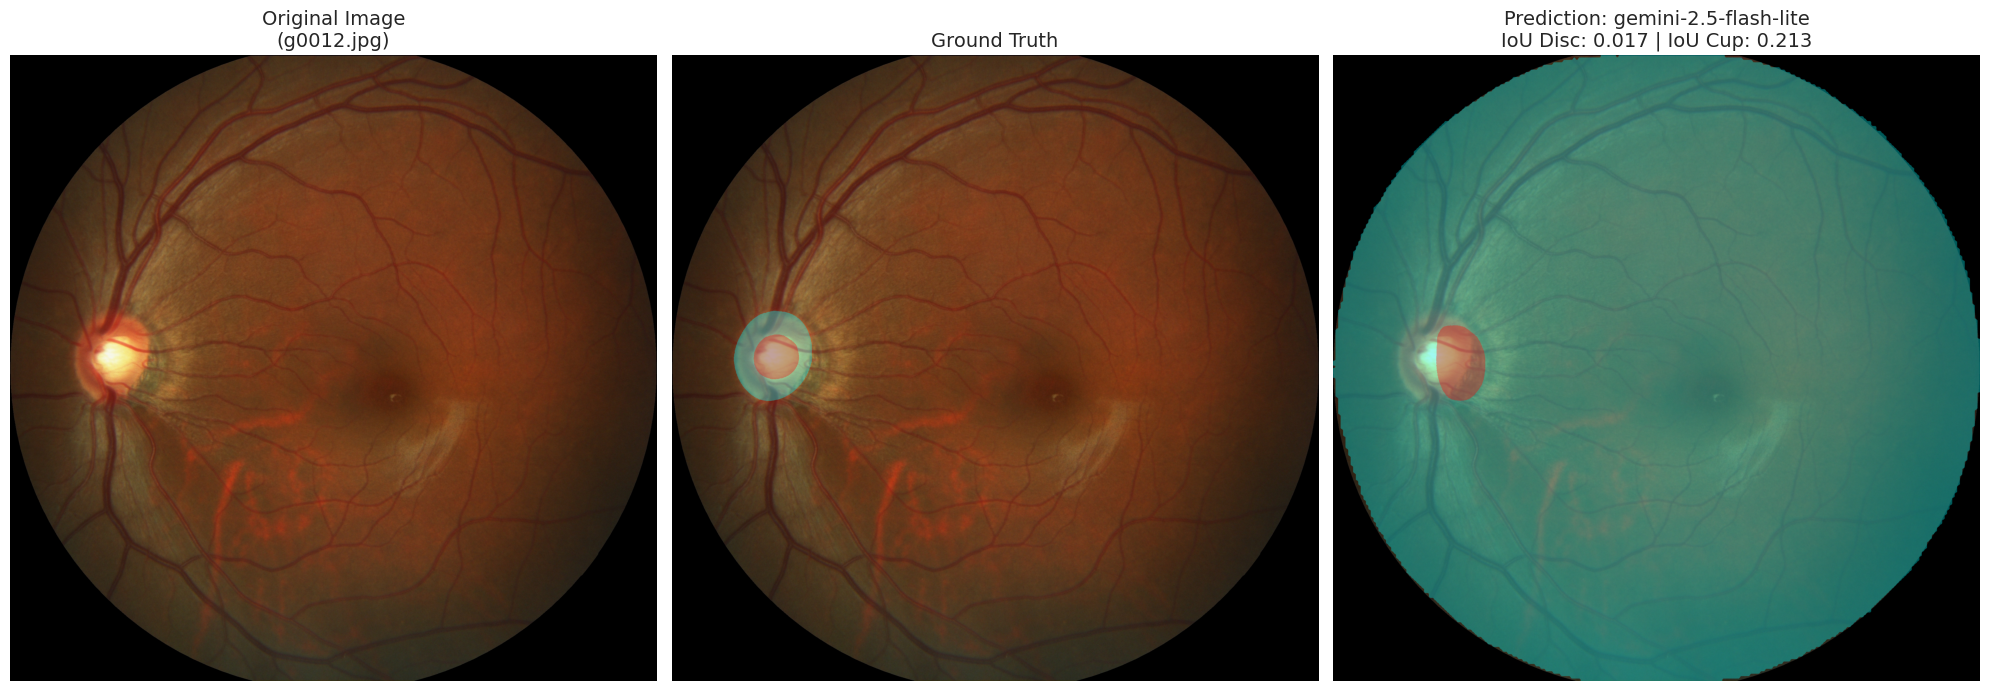

In [5]:
# %% [markdown]
"""
# 05 Qualitative Analysis · **Optic Disc/Cup Segmentation**

*Last sync 01 Aug 2025*

This notebook provides tools to perform a qualitative check on the model's output from a previous REFUGE2 evaluation run. It loads a cached prediction from the model-specific `predictions_<model_name>/` directory and displays a three-panel comparison for any given image.

**Instructions:**
- Ensure you have run the `04_model_evaluation` notebook for the REFUGE2 dataset with `SAVE_PREDICTIONS = True`.
- Set the `MODEL_TO_VISUALIZE` variable in the last cell to the model you want to inspect.
- To visualize a specific image, set the `IMAGE_TO_VISUALIZE` variable to the desired filename (e.g., 'g0001.jpg').
- If you leave `IMAGE_TO_VISUALIZE` as `None`, the script will automatically find and display the first available case for the specified model.
"""

# %%
# ---------- Preamble & Setup ----------
import os, json, base64, dataclasses, logging, io
from pathlib import Path
from typing import List, Tuple, Dict

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont, ImageColor, UnidentifiedImageError
from dotenv import load_dotenv, find_dotenv

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s — %(levelname)s — %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)

# %%
# ---------- Dataset Path & Helper Functions ----------
load_dotenv(find_dotenv(), override=False)

dataset_dir = Path(os.getenv("REFUGE_DIR", "data/REFUGE2")).expanduser().resolve()
if not dataset_dir.is_dir():
    raise FileNotFoundError(f"Dataset directory not found at {dataset_dir}.")
logging.info("REFUGE2 dataset found at %s", dataset_dir)

@dataclasses.dataclass(frozen=True)
class SegmentationMask:
    """A dataclass to hold a single segmentation mask's data."""
    y0: int
    x0: int
    y1: int
    x1: int
    mask: np.ndarray # Full-size mask [img_height, img_width] with values 0..255
    label: str

def calculate_iou(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Calculates Intersection over Union (IoU) for boolean masks."""
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    if np.sum(union) == 0: return 1.0
    return np.sum(intersection) / np.sum(union)

def load_prediction_from_cache(prediction_path: Path) -> List[SegmentationMask]:
    """Loads and parses a cached prediction JSON file into SegmentationMask objects."""
    if not prediction_path.exists():
        logging.error(f"Prediction cache file not found: {prediction_path}")
        return []
    
    with open(prediction_path, 'r') as f:
        try:
            items = json.load(f)
        except json.JSONDecodeError:
            logging.error(f"Could not decode JSON from cached file: {prediction_path}")
            return []

    masks = []
    for item in items:
        try:
            y0, x0, y1, x1 = item["box_2d_absolute"]
            label = item["label"].lower()
            
            png_b64_str = item["mask_b64"]
            png_bytes = base64.b64decode(png_b64_str.removeprefix("data:image/png;base64,"))
            mask_img = Image.open(io.BytesIO(png_bytes))
            mask_np = np.array(mask_img)

            masks.append(SegmentationMask(y0, x0, y1, x1, mask_np, label))
        except (KeyError, IndexError, TypeError, base64.binascii.Error, UnidentifiedImageError) as e:
            logging.warning(f"Skipping malformed item in cached prediction: {item}. Error: {e}")
            continue
    return masks

def parse_ground_truth_mask(mask_path: Path) -> list[SegmentationMask]:
    """
    Parses a REFUGE2 ground truth BMP/PNG file into separate SegmentationMasks for disc and cup.
    """
    try:
        mask_img = Image.open(mask_path).convert("RGB")
        mask_data = np.array(mask_img)
    except (FileNotFoundError, UnidentifiedImageError) as e:
        logging.error("Could not read ground truth mask file %s: %s", mask_path, e)
        return []

    CUP_COLOR = np.array([0, 0, 0])
    DISC_COLOR = np.array([128, 128, 128])

    is_cup = np.all(mask_data == CUP_COLOR, axis=-1)
    is_disc_ring = np.all(mask_data == DISC_COLOR, axis=-1)
    is_disc = is_cup | is_disc_ring

    masks = []
    for label, binary_mask_data in [("optic cup", is_cup), ("optic disc", is_disc)]:
        if not np.any(binary_mask_data): continue
        rows, cols = np.where(binary_mask_data)
        y0, y1 = rows.min(), rows.max()
        x0, x1 = cols.min(), cols.max()
        full_mask_np = binary_mask_data.astype(np.uint8) * 255
        masks.append(SegmentationMask(y0, x0, y1, x1, full_mask_np, label))
    return masks

def plot_segmentation_overlays(img: Image.Image, segmentation_masks: list[SegmentationMask]) -> Image.Image:
    """Draws all masks and bounding boxes on an image for visualization."""
    if not segmentation_masks:
        return img.convert("RGB")

    # Define consistent colors for disc and cup
    color_map = {"optic disc": "cyan", "optic cup": "red"}
    default_color = "yellow"

    img_with_masks = img.copy().convert("RGBA")
    draw = ImageDraw.Draw(img_with_masks)

    # Sort masks to ensure smaller ones (cup) are drawn on top of larger ones (disc)
    sorted_masks = sorted(segmentation_masks, key=lambda m: np.sum(m.mask), reverse=True)

    for seg_mask in sorted_masks:
        color = color_map.get(seg_mask.label, default_color)
        
        # Create a colored overlay for the mask
        mask_layer = Image.new("RGBA", img_with_masks.size)
        mask_draw = ImageDraw.Draw(mask_layer)
        
        # Get the binary mask from the numpy array
        pil_mask = Image.fromarray((seg_mask.mask > 127).astype(np.uint8) * 255)
        
        # Fill the shape on the new layer
        color_rgba = ImageColor.getrgb(color) + (90,) # Add alpha transparency
        mask_draw.bitmap((0,0), pil_mask, fill=color_rgba)
        
        # Composite the layer
        img_with_masks = Image.alpha_composite(img_with_masks, mask_layer)
        
        # Draw the bounding box on top
        box_color = ImageColor.getrgb(color)
        box = ((seg_mask.x0, seg_mask.y0), (seg_mask.x1, seg_mask.y1))
        draw.rectangle(box, outline=box_color, width=4)

    return img_with_masks.convert("RGB")


def find_complete_case(model_name: str) -> str | None:
    """
    Scans a model's predictions directory and finds the first case that has a
    corresponding original image and ground truth mask in the REFUGE2 structure.
    """
    model_name_safe = model_name.replace("/", "_")
    predictions_dir = dataset_dir / f"predictions_{model_name_safe}"
    
    if not predictions_dir.exists():
        logging.error(f"Predictions directory not found for model '{model_name}': {predictions_dir}")
        return None

    # Get all potential images and masks
    all_images = list(dataset_dir.glob("**/image/*.jpg"))
    bmp_masks = {p.stem: p for p in dataset_dir.glob("**/mask/*.bmp")}
    png_masks = {p.stem: p for p in dataset_dir.glob("**/mask/*.png")}
    full_mask_map = {**bmp_masks, **png_masks}

    for pred_file in sorted(predictions_dir.glob("*.json")):
        stem = pred_file.stem
        # Check if this prediction has a corresponding image and mask
        if stem in full_mask_map and any(img.stem == stem for img in all_images):
            return f"{stem}.jpg"
            
    return None

def visualize_single_case(image_name: str, model_name: str):
    """
    Generates and displays a 3-panel plot comparing the original image,
    ground truth, and the model's prediction for the REFUGE2 dataset.
    """
    model_name_safe = model_name.replace("/", "_")
    
    # Find the full path to the image
    image_path = next(dataset_dir.glob(f"**/image/{image_name}"), None)
    if not image_path:
        logging.error(f"Image file does not exist: {image_name}")
        return
        
    # Find the corresponding mask path
    bmp_masks = {p.stem: p for p in dataset_dir.glob("**/mask/*.bmp")}
    png_masks = {p.stem: p for p in dataset_dir.glob("**/mask/*.png")}
    full_mask_map = {**bmp_masks, **png_masks}
    gt_mask_path = full_mask_map.get(image_path.stem)

    prediction_path = dataset_dir / f"predictions_{model_name_safe}" / f"{image_path.stem}.json"
    
    if not prediction_path.exists():
        logging.error(f"Prediction file does not exist for model '{model_name}': {prediction_path}")
        return

    logging.info(f"Loading original image: {image_path.name}")
    original_image = Image.open(image_path)
    
    logging.info(f"Loading and parsing ground truth: {gt_mask_path.name if gt_mask_path else 'N/A'}")
    gt_masks = parse_ground_truth_mask(gt_mask_path) if gt_mask_path else []

    logging.info(f"Loading prediction for model '{model_name}' from cache: {prediction_path.name}")
    predicted_masks = load_prediction_from_cache(prediction_path)

    fig, axes = plt.subplots(1, 3, figsize=(20, 7))
    plt.style.use('default')

    # Panel 1: Original Image
    axes[0].imshow(original_image)
    axes[0].set_title(f"Original Image\n({image_name})", fontsize=14)
    axes[0].axis('off')

    # Panel 2: Ground Truth Overlay
    gt_overlay = plot_segmentation_overlays(original_image, gt_masks)
    axes[1].imshow(gt_overlay)
    axes[1].set_title("Ground Truth", fontsize=14)
    axes[1].axis('off')

    # Panel 3: Prediction Overlay with IoU scores
    pred_overlay = plot_segmentation_overlays(original_image, predicted_masks)
    axes[2].imshow(pred_overlay)
    
    # Calculate IoU for title
    gt_map = {m.label: m.mask for m in gt_masks}
    pred_map = {m.label: m.mask for m in predicted_masks}
    
    iou_disc = calculate_iou(gt_map.get('optic disc', np.zeros(original_image.size[::-1])) > 127, pred_map.get('optic disc', np.zeros(original_image.size[::-1])) > 127)
    iou_cup = calculate_iou(gt_map.get('optic cup', np.zeros(original_image.size[::-1])) > 127, pred_map.get('optic cup', np.zeros(original_image.size[::-1])) > 127)
    
    title = f"Prediction: {model_name}\nIoU Disc: {iou_disc:.3f} | IoU Cup: {iou_cup:.3f}"
    axes[2].set_title(title, fontsize=14)
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

# %% [markdown]
"""
### Visualize a Specific Image

To use this notebook, modify the variables below.
"""

# %%
# ---------- Specify Model and Image, then Run Visualization ----------

# <<< --- REQUIRED: Set the model name you want to visualize --- >>>
MODEL_TO_VISUALIZE = "gemini-2.5-flash-lite"

# <<< --- OPTIONAL: Set a specific filename to visualize --- >>>
# If you leave this as None, the script will automatically find the first
# available image for the specified model.
IMAGE_TO_VISUALIZE = None 

# --- Find and Visualize a Case ---
if not MODEL_TO_VISUALIZE:
    logging.error("MODEL_TO_VISUALIZE is not set. Please specify a model name.")
else:
    if not IMAGE_TO_VISUALIZE:
        logging.info(f"IMAGE_TO_VISUALIZE not set. Searching for a complete case for model '{MODEL_TO_VISUALIZE}'...")
        IMAGE_TO_VISUALIZE = find_complete_case(MODEL_TO_VISUALIZE)
        if IMAGE_TO_VISUALIZE:
            logging.info(f"Found complete case: '{IMAGE_TO_VISUALIZE}'. Visualizing...")
        else:
            logging.error(f"Could not find any complete case for model '{MODEL_TO_VISUALIZE}'.")
            logging.error("Please ensure you have run the evaluation notebook for this model and that predictions were saved.")

    if IMAGE_TO_VISUALIZE:
        # Check if the image actually exists before trying to visualize
        if not next(dataset_dir.glob(f"**/image/{IMAGE_TO_VISUALIZE}"), None):
            logging.error(f"The specified or found image '{IMAGE_TO_VISUALIZE}' does not exist in the dataset.")
        else:
            visualize_single_case(IMAGE_TO_VISUALIZE, MODEL_TO_VISUALIZE)


# Performance Metrics Re-Evaluation

2025-08-01 15:04:37 — INFO — Re-analysis notebook start.
2025-08-01 15:04:37 — INFO — Installing python-dotenv (missing)
2025-08-01 15:04:38 — INFO — Installing Pillow (missing)
2025-08-01 15:04:39 — INFO — REFUGE2 dataset found at D:\Projects\gemini_image_segmentation\data\REFUGE2
2025-08-01 15:04:39 — INFO — Found 1200 cached predictions for model 'gemini-2.5-flash-lite'.
2025-08-01 15:04:39 — INFO — Starting re-analysis with up to 12 threads.


Re-analyzing gemini-2.5-flash-lite:   0%|          | 0/1200 [00:00<?, ?it/s]

2025-08-01 15:05:57 — INFO — Excluding cases with IoU < 0.5 from stats calculations.
2025-08-01 15:05:57 — INFO — Saved re-analysis summary to D:\Projects\gemini_image_segmentation\data\REFUGE2\reanalysis_summary_gemini-2.5-flash-lite_thresh_0.5.json


---------------------------------------------
       Re-Analysis Report: gemini-2.5-flash-lite on REFUGE2
---------------------------------------------
Total Cached Predictions Analyzed: 1200
New IoU Threshold for Success:     0.5
Excluding Low IoU from Stats:    True

--- Performance Metrics ---
Mean IoU (Disc):      0.6694 (95% CI: 0.6587 - 0.6798) on 342 images
Mean IoU (Cup):       0.6178 (95% CI: 0.5998 - 0.6388) on 77 images
Mean Dice (Disc):     0.7974 (95% CI: 0.7895 - 0.8055)
Mean Dice (Cup):      0.7605 (95% CI: 0.7466 - 0.7751)

--- Clinical Metric ---
vCDR MAE:             0.2259 (95% CI: 0.2172 - 0.2341)

--- Failure Analysis (New Threshold) ---
False Negatives (Disc / Cup): 11 (0.9%) / 444 (37.0%)
Low IoU Failures (Disc / Cup): 847 (70.6%) / 679 (56.6%)
---------------------------------------------


2025-08-01 15:05:59 — INFO — Saved re-analysis IoU plot to D:\Projects\gemini_image_segmentation\data\REFUGE2\reanalysis_iou_dist_gemini-2.5-flash-lite_thresh_0.5.png


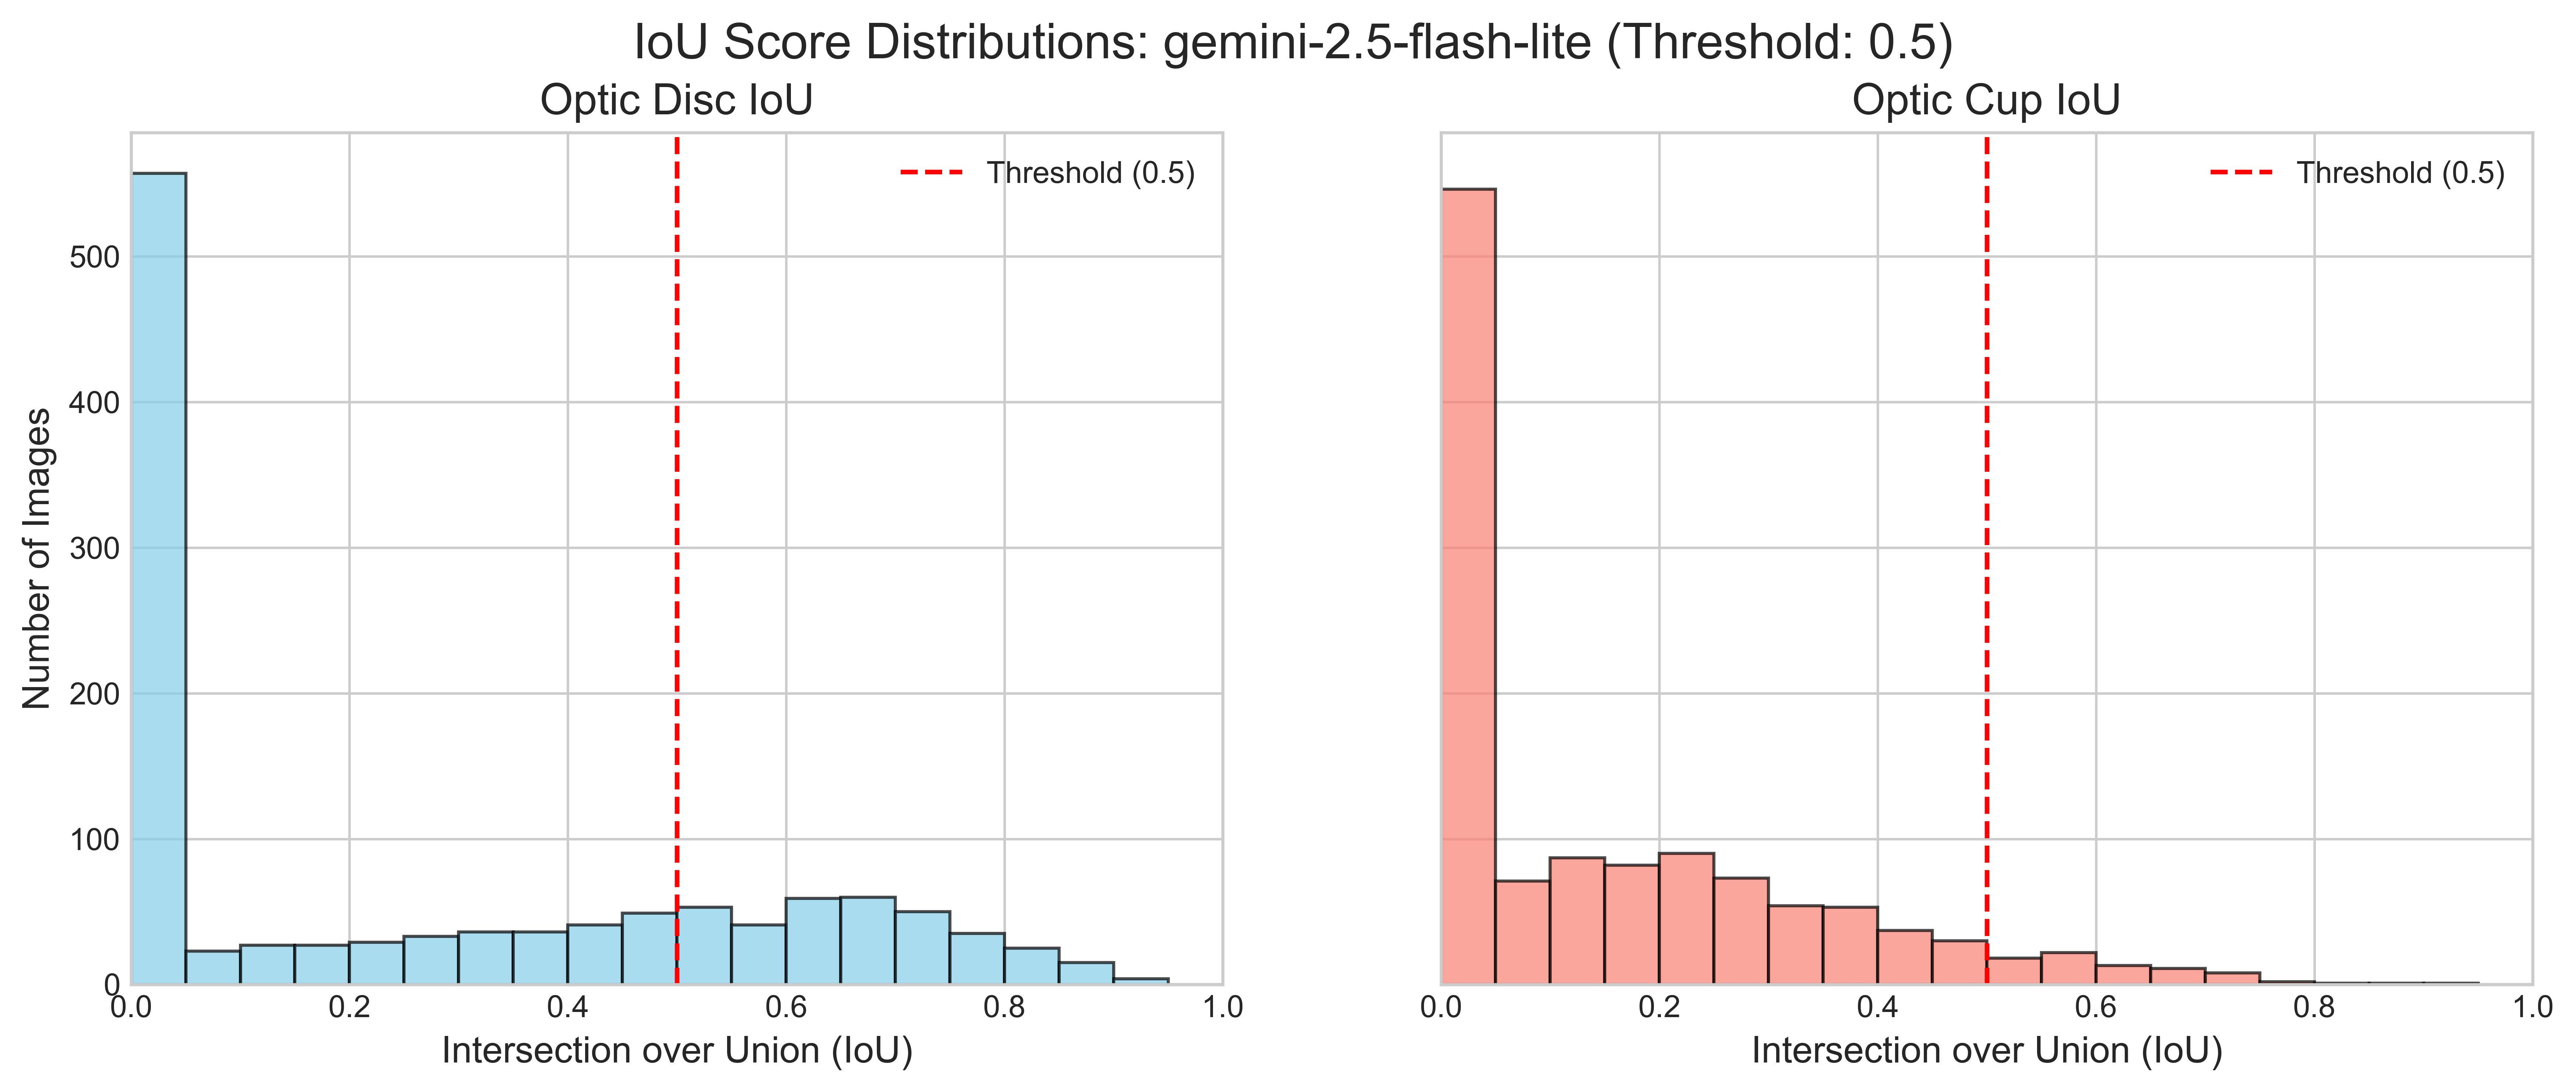

"\n✅ Re-analysis complete. The report above summarizes the model's performance using the new threshold.\n"

In [2]:
# %% [markdown]
"""
# 06 Results Re-Analysis Tool (Multithreaded)

*Last sync 01 Aug 2025*

This notebook re-calculates and re-plots evaluation metrics from a completed run's
cached predictions for the REFUGE2 dataset. It allows for rapid testing of
different IoU thresholds without needing to re-run expensive API calls. It uses
multithreading to accelerate file processing and saves a detailed JSON summary.

**Instructions:**
1.  Ensure you have run the `04_model_evaluation` notebook for the REFUGE2 dataset
    with `SAVE_PREDICTIONS = True`.
2.  Set the `MODEL_TO_ANALYZE` variable below to the model you want to inspect.
3.  Set the `NEW_LOW_IOU_THRESHOLD` to the desired value for defining a "successful" detection.
4.  Use the `EXCLUDE_LOW_IOU_FROM_STATS` toggle to control the analysis behavior:
    - `True`: (Default) Excludes low-IoU cases from summary statistics (mean, CI).
      The plot will still show all cases but with a red threshold line.
    - `False`: Includes all cases (even IoU=0) in summary statistics and plots.
      This gives a view of performance across the entire dataset.
"""

# %%
# ---------- Preamble & Setup ----------
import sys, logging, os, subprocess, importlib.util, json, io, base64, dataclasses
from datetime import datetime
from pathlib import Path
from typing import Tuple, List, Dict, Optional
from concurrent.futures import ThreadPoolExecutor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError
from tqdm.notebook import tqdm
from dotenv import load_dotenv, find_dotenv

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s — %(levelname)s — %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)
logging.info("Re-analysis notebook start.")

# %%
# ---------- Ensure helper packages ----------
def _ensure(pkg: str):
    """Checks if a package is installed and installs it if not."""
    if importlib.util.find_spec(pkg) is None:
        logging.info("Installing %s (missing)", pkg)
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "--quiet"])

for extra in ("python-dotenv", "tqdm", "matplotlib", "numpy", "Pillow", "pandas"):
    _ensure(extra)

# %%
# ---------- Dataset Path & Helper Functions ----------
load_dotenv(find_dotenv(), override=False)

dataset_dir = Path(os.getenv("REFUGE_DIR", "data/REFUGE2")).expanduser().resolve()
if not dataset_dir.is_dir():
    raise FileNotFoundError(f"Dataset directory not found at {dataset_dir}.")
logging.info("REFUGE2 dataset found at %s", dataset_dir)


@dataclasses.dataclass(frozen=True)
class SegmentationMask:
    """A dataclass to hold a single segmentation mask's data."""
    y0: int
    x0: int
    y1: int
    x1: int
    mask: np.ndarray # Full-size mask [img_height, img_width] with values 0..255
    label: str

def load_prediction_from_cache(prediction_path: Path) -> List[SegmentationMask]:
    """Loads and parses a cached prediction JSON file into SegmentationMask objects."""
    if not prediction_path.exists():
        return []
    
    with open(prediction_path, 'r') as f:
        try:
            items = json.load(f)
        except json.JSONDecodeError:
            return []

    masks = []
    for item in items:
        try:
            y0, x0, y1, x1 = item["box_2d_absolute"]
            label = item["label"].lower()
            
            png_b64_str = item["mask_b64"]
            png_bytes = base64.b64decode(png_b64_str.removeprefix("data:image/png;base64,"))
            mask_img = Image.open(io.BytesIO(png_bytes))
            mask_np = np.array(mask_img)

            masks.append(SegmentationMask(y0, x0, y1, x1, mask_np, label))
        except (KeyError, IndexError, TypeError, base64.binascii.Error, UnidentifiedImageError):
            continue
    return masks

def parse_ground_truth_mask(mask_path: Path) -> list[SegmentationMask]:
    """
    Parses a REFUGE2 ground truth BMP/PNG file into separate SegmentationMasks for disc and cup.
    """
    try:
        mask_img = Image.open(mask_path).convert("RGB")
        mask_data = np.array(mask_img)
    except (FileNotFoundError, UnidentifiedImageError):
        return []

    CUP_COLOR = np.array([0, 0, 0])
    DISC_COLOR = np.array([128, 128, 128])

    is_cup = np.all(mask_data == CUP_COLOR, axis=-1)
    is_disc_ring = np.all(mask_data == DISC_COLOR, axis=-1)
    is_disc = is_cup | is_disc_ring

    masks = []
    for label, binary_mask_data in [("optic cup", is_cup), ("optic disc", is_disc)]:
        if not np.any(binary_mask_data): continue
        rows, cols = np.where(binary_mask_data)
        y0, y1 = rows.min(), rows.max()
        x0, x1 = cols.min(), cols.max()
        full_mask_np = binary_mask_data.astype(np.uint8) * 255
        masks.append(SegmentationMask(y0, x0, y1, x1, full_mask_np, label))
    return masks

# %%
# ---------- Metric Calculation Functions ----------

def calculate_iou(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Calculates Intersection over Union (IoU) for boolean masks."""
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    if np.sum(union) == 0: return 1.0
    return np.sum(intersection) / np.sum(union)

def calculate_dice(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Calculates the Dice Coefficient for boolean masks."""
    intersection = np.sum(np.logical_and(y_true, y_pred))
    denominator = np.sum(y_true) + np.sum(y_pred)
    if denominator == 0: return 1.0
    return (2. * intersection) / (denominator + 1e-7)

def calculate_vcdr(mask_cup: np.ndarray, mask_disc: np.ndarray) -> float:
    """Calculates the vertical cup-to-disc ratio from binary masks."""
    try:
        cup_rows = np.where(mask_cup)[0]
        disc_rows = np.where(mask_disc)[0]
        if cup_rows.size == 0 or disc_rows.size == 0: return 0.0
        h_cup = cup_rows.max() - cup_rows.min() + 1
        h_disc = disc_rows.max() - disc_rows.min() + 1
        return h_cup / h_disc
    except Exception:
        return 0.0

def calculate_bootstrap_ci(data: List[float], n_resamples: int = 1000) -> Tuple[float, float]:
    """Calculates the 95% confidence interval for a list of numbers using bootstrapping."""
    if not data or len(data) < 2: return 0.0, 0.0
    bootstrapped_means = [np.mean(np.random.choice(data, size=len(data), replace=True)) for _ in range(n_resamples)]
    return np.percentile(bootstrapped_means, 2.5), np.percentile(bootstrapped_means, 97.5)

# %% [markdown]
"""
### Re-Analysis Execution

This section loads the cached predictions, recalculates all metrics in parallel, and then generates a new report and plot based on the parameters you set below.
"""

# %%
# ---------- Main Re-Analysis Loop ----------

# <<< --- PARAMETERS TO CONTROL THE RE-ANALYSIS --- >>>
MODEL_TO_ANALYZE = "gemini-2.5-flash-lite"
NEW_LOW_IOU_THRESHOLD = 0.5
EXCLUDE_LOW_IOU_FROM_STATS = True # Set to False to include all cases in stats/plots
MAX_WORKERS = os.cpu_count() or 4 # Use all available CPU cores, or default to 4

# --- Setup paths and find prediction files ---
model_name_safe = MODEL_TO_ANALYZE.replace("/", "_")
predictions_dir = dataset_dir / f"predictions_{model_name_safe}"
if not predictions_dir.is_dir():
    raise FileNotFoundError(f"Predictions directory not found for model '{MODEL_TO_ANALYZE}'. Please run the evaluation script first.")

prediction_files = list(predictions_dir.glob("*.json"))
if not prediction_files:
    raise FileNotFoundError(f"No prediction files found in {predictions_dir}.")

logging.info(f"Found {len(prediction_files)} cached predictions for model '{MODEL_TO_ANALYZE}'.")
logging.info(f"Starting re-analysis with up to {MAX_WORKERS} threads.")


# --- Create a complete mask map for efficient lookup ---
bmp_masks = {p.stem: p for p in dataset_dir.glob("**/mask/*.bmp")}
png_masks = {p.stem: p for p in dataset_dir.glob("**/mask/*.png")}
full_mask_map = {**bmp_masks, **png_masks}

# --- Worker function for parallel processing ---
def process_single_prediction(pred_path: Path) -> Optional[Dict]:
    """Processes a single prediction file to calculate all relevant metrics."""
    image_stem = pred_path.stem
    
    predicted_masks = load_prediction_from_cache(pred_path)
    
    mask_path = full_mask_map.get(image_stem)
    if not mask_path:
        return None
    
    gt_masks = parse_ground_truth_mask(mask_path)
    if not gt_masks:
        return None

    gt_map = {m.label: m.mask for m in gt_masks}
    pred_map = {m.label: m.mask for m in predicted_masks}

    gt_disc_mask = gt_map.get('optic disc')
    if gt_disc_mask is None:
        return None # Skip if essential ground truth is missing
    
    mask_shape = gt_disc_mask.shape
    default_mask = np.zeros(mask_shape, dtype=np.uint8)

    pred_disc_mask = pred_map.get('optic disc', default_mask)
    pred_cup_mask = pred_map.get('optic cup', default_mask)
    gt_cup_mask = gt_map.get('optic cup', default_mask)

    # Recalculate all metrics
    iou_disc = calculate_iou(gt_disc_mask > 127, pred_disc_mask > 127)
    iou_cup = calculate_iou(gt_cup_mask > 127, pred_cup_mask > 127)
    dice_disc = calculate_dice(gt_disc_mask > 127, pred_disc_mask > 127)
    dice_cup = calculate_dice(gt_cup_mask > 127, pred_cup_mask > 127)
    vcdr_gt = calculate_vcdr(gt_cup_mask > 127, gt_disc_mask > 127)
    vcdr_pred = calculate_vcdr(pred_cup_mask > 127, pred_disc_mask > 127)

    return {
        "image_path": f"{image_stem}.jpg", "iou_disc": iou_disc, "iou_cup": iou_cup,
        "dice_disc": dice_disc, "dice_cup": dice_cup, "vcdr_gt": vcdr_gt, "vcdr_pred": vcdr_pred
    }

# --- Recalculate metrics in parallel ---
recalculated_results = []
with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    results_iterator = executor.map(process_single_prediction, prediction_files)
    for result in tqdm(results_iterator, total=len(prediction_files), desc=f"Re-analyzing {model_name_safe}"):
        if result is not None:
            recalculated_results.append(result)


# %% [markdown]
"""
### New Results Summary

The following report is generated from the recalculated metrics using your specified IoU threshold.
"""

# %%
# ---------- Aggregate, Display, and Save New Results ----------

if recalculated_results:
    df = pd.DataFrame(recalculated_results)
    df["vcdr_abs_err"] = (df.vcdr_pred - df.vcdr_gt).abs()

    # --- Determine which data to use for STATS based on the toggle ---
    if EXCLUDE_LOW_IOU_FROM_STATS:
        logging.info(f"Excluding cases with IoU < {NEW_LOW_IOU_THRESHOLD} from stats calculations.")
        disc_runs_for_stats = df[df['iou_disc'] >= NEW_LOW_IOU_THRESHOLD]
        cup_runs_for_stats = df[df['iou_cup'] >= NEW_LOW_IOU_THRESHOLD]
    else:
        logging.info("Including all cases (even IoU=0) in stats calculations.")
        disc_runs_for_stats = df
        cup_runs_for_stats = df
    
    # --- Performance Metrics ---
    mean_iou_disc = disc_runs_for_stats['iou_disc'].mean()
    mean_iou_cup = cup_runs_for_stats['iou_cup'].mean()
    mean_dice_disc = disc_runs_for_stats['dice_disc'].mean()
    mean_dice_cup = cup_runs_for_stats['dice_cup'].mean()
    vcdr_mae = df[df['vcdr_gt'] > 0]['vcdr_abs_err'].mean()

    # --- Failure Analysis (based on the new threshold) ---
    total_runs = len(df)
    fn_disc_failures = len(df[df['iou_disc'] == 0])
    fn_cup_failures = len(df[df['iou_cup'] == 0])
    low_iou_disc_failures = len(df[(df['iou_disc'] > 0) & (df['iou_disc'] < NEW_LOW_IOU_THRESHOLD)])
    low_iou_cup_failures = len(df[(df['iou_cup'] > 0) & (df['iou_cup'] < NEW_LOW_IOU_THRESHOLD)])

    # --- Confidence Intervals ---
    iou_disc_ci = calculate_bootstrap_ci(disc_runs_for_stats['iou_disc'].tolist())
    iou_cup_ci = calculate_bootstrap_ci(cup_runs_for_stats['iou_cup'].tolist())
    dice_disc_ci = calculate_bootstrap_ci(disc_runs_for_stats['dice_disc'].tolist())
    dice_cup_ci = calculate_bootstrap_ci(cup_runs_for_stats['dice_cup'].tolist())
    vcdr_mae_ci = calculate_bootstrap_ci(df[df['vcdr_gt'] > 0]['vcdr_abs_err'].tolist())

    print("---" * 15)
    print(f"       Re-Analysis Report: {MODEL_TO_ANALYZE} on REFUGE2")
    print("---" * 15)
    print(f"Total Cached Predictions Analyzed: {total_runs}")
    print(f"New IoU Threshold for Success:     {NEW_LOW_IOU_THRESHOLD}")
    print(f"Excluding Low IoU from Stats:    {EXCLUDE_LOW_IOU_FROM_STATS}")
    
    print("\n--- Performance Metrics ---")
    print(f"Mean IoU (Disc):      {mean_iou_disc:.4f} (95% CI: {iou_disc_ci[0]:.4f} - {iou_disc_ci[1]:.4f}) on {len(disc_runs_for_stats)} images")
    print(f"Mean IoU (Cup):       {mean_iou_cup:.4f} (95% CI: {iou_cup_ci[0]:.4f} - {iou_cup_ci[1]:.4f}) on {len(cup_runs_for_stats)} images")
    print(f"Mean Dice (Disc):     {mean_dice_disc:.4f} (95% CI: {dice_disc_ci[0]:.4f} - {dice_disc_ci[1]:.4f})")
    print(f"Mean Dice (Cup):      {mean_dice_cup:.4f} (95% CI: {dice_cup_ci[0]:.4f} - {dice_cup_ci[1]:.4f})")
    
    print("\n--- Clinical Metric ---")
    print(f"vCDR MAE:             {vcdr_mae:.4f} (95% CI: {vcdr_mae_ci[0]:.4f} - {vcdr_mae_ci[1]:.4f})")

    print("\n--- Failure Analysis (New Threshold) ---")
    print(f"False Negatives (Disc / Cup): {fn_disc_failures} ({fn_disc_failures/total_runs:.1%}) / {fn_cup_failures} ({fn_cup_failures/total_runs:.1%})")
    print(f"Low IoU Failures (Disc / Cup): {low_iou_disc_failures} ({low_iou_disc_failures/total_runs:.1%}) / {low_iou_cup_failures} ({low_iou_cup_failures/total_runs:.1%})")
    print("---" * 15)

    # --- Create and save summary dictionary ---
    summary_data = {
        "reanalysis_timestamp": datetime.now().isoformat(),
        "total_cached_predictions_analyzed": total_runs,
        "settings": {
            "model_analyzed": MODEL_TO_ANALYZE,
            "new_low_iou_threshold": NEW_LOW_IOU_THRESHOLD,
            "excluded_low_iou_from_stats": EXCLUDE_LOW_IOU_FROM_STATS,
        },
        "performance_metrics": {
            "mean_iou_disc": mean_iou_disc, "mean_iou_cup": mean_iou_cup,
            "mean_dice_disc": mean_dice_disc, "mean_dice_cup": mean_dice_cup,
            "mean_iou_disc_95_ci": iou_disc_ci, "mean_iou_cup_95_ci": iou_cup_ci,
            "mean_dice_disc_95_ci": dice_disc_ci, "mean_dice_cup_95_ci": dice_cup_ci,
            "num_images_disc_stats": len(disc_runs_for_stats),
            "num_images_cup_stats": len(cup_runs_for_stats),
        },
        "clinical_metrics": {
            "vcdr_mae": vcdr_mae,
            "vcdr_mae_95_ci": vcdr_mae_ci,
        },
        "failure_counts": {
            "false_negatives_disc": fn_disc_failures,
            "false_negatives_cup": fn_cup_failures,
            "low_iou_failures_disc": low_iou_disc_failures,
            "low_iou_failures_cup": low_iou_cup_failures,
        }
    }
    
    summary_path = dataset_dir / f"reanalysis_summary_{model_name_safe}_thresh_{NEW_LOW_IOU_THRESHOLD}.json"
    with open(summary_path, 'w') as f:
        json.dump(summary_data, f, indent=4)
    logging.info(f"Saved re-analysis summary to {summary_path}")

    # --- Visualize and save the distribution of IoU scores ---
    # PLOTS WILL ALWAYS SHOW ALL DATA, regardless of the stats toggle.
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=600, sharey=True)
    fig.suptitle(f'IoU Score Distributions: {MODEL_TO_ANALYZE} (Threshold: {NEW_LOW_IOU_THRESHOLD})', fontsize=16)

    axes[0].hist(df['iou_disc'], bins=20, range=(0,1), edgecolor='black', alpha=0.7, color='skyblue')
    axes[0].set_title('Optic Disc IoU', fontsize=14)
    axes[0].set_xlabel('Intersection over Union (IoU)', fontsize=12)
    axes[0].set_ylabel('Number of Images', fontsize=12)
    axes[0].axvline(NEW_LOW_IOU_THRESHOLD, color='r', linestyle='--', label=f'Threshold ({NEW_LOW_IOU_THRESHOLD})')
    axes[0].legend()
    axes[0].set_xlim(0, 1)

    axes[1].hist(df['iou_cup'], bins=20, range=(0,1), edgecolor='black', alpha=0.7, color='salmon')
    axes[1].set_title('Optic Cup IoU', fontsize=14)
    axes[1].set_xlabel('Intersection over Union (IoU)', fontsize=12)
    axes[1].axvline(NEW_LOW_IOU_THRESHOLD, color='r', linestyle='--', label=f'Threshold ({NEW_LOW_IOU_THRESHOLD})')
    axes[1].legend()
    axes[1].set_xlim(0, 1)

    plot_path = dataset_dir / f"reanalysis_iou_dist_{model_name_safe}_thresh_{NEW_LOW_IOU_THRESHOLD}.png"
    plt.savefig(plot_path, bbox_inches='tight')
    logging.info(f"Saved re-analysis IoU plot to {plot_path}")
    plt.show()
else:
    print("No recalculated results were generated. Check if prediction files exist.")

# %% [markdown]
"""
✅ Re-analysis complete. The report above summarizes the model's performance using the new threshold.
"""
